Moran's I: 0.3170149346843211, p-value: 0.003
Ridge Regression Coefficient for X: [0.50000523]
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:          48
Mean dependent var  :  38197.6307                Number of Variables   :           3
S.D. dependent var  :   6067.7717                Degrees of Freedom    :          45
Pseudo R-squared    :      1.0000
Spatial Pseudo R-squared:  1.0000

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.33931         1.25589         0.27018         0.78702
               var_1         0.5

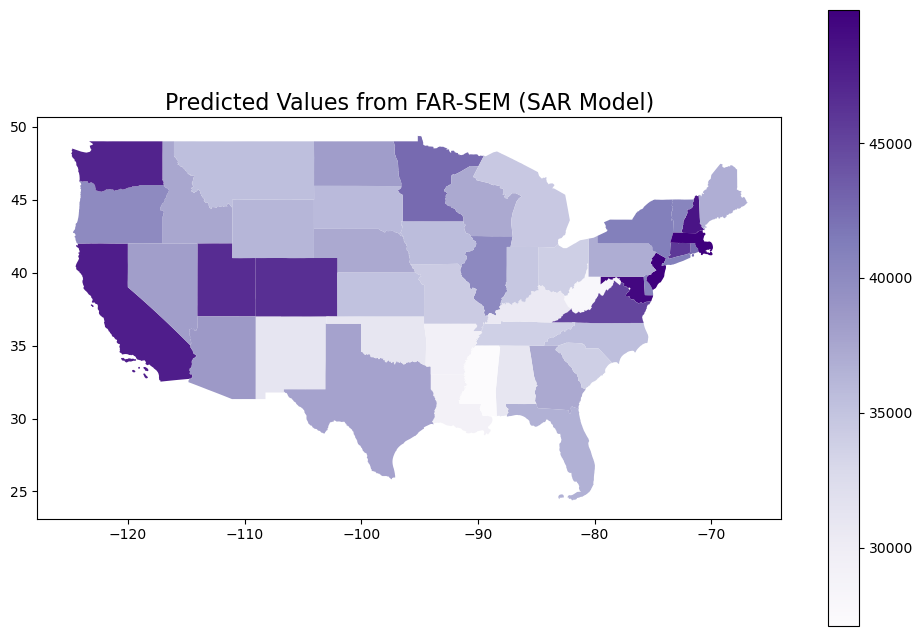

In [45]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pysal.lib import weights
from pysal.model.spreg import GM_Lag
from esda.moran import Moran  # Ensure standalone esda is installed
from sklearn.linear_model import Ridge  # Regularized model for addressing overfitting


# Load USA shapefile
shapefile_path = "shapefile"  # Replace with actual shapefile path
USA_states = gpd.read_file(shapefile_path)

# Filter for the 50 main states
main_states = [
    "Alabama", "Arizona", "Arkansas", "California", "Colorado", 
    "Connecticut", "Delaware", "Florida", "Georgia", "Idaho", 
    "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", 
    "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", 
    "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", 
    "New Hampshire", "New Jersey", "New Mexico", "New York", 
    "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", 
    "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", 
    "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", 
    "West Virginia", "Wisconsin", "Wyoming"
]
usa_map = USA_states[USA_states['NAME'].isin(main_states)]

# Load real data for household income
household_income = pd.read_excel("Median household income.xlsx")  
household_income.rename(columns={'State': 'NAME'}, inplace=True)  # Match column names for merge
usa_map = usa_map.merge(household_income, on='NAME', how='left')

# Prepare spatial weight matrix
threshold = 500000  # In meters (500 km)  # Define distance threshold for neighbors (500 km)
w = weights.Queen.from_dataframe(usa_map, use_index=True)
w.transform = "r"

# Define variables for spatial regression
usa_map['X'] = usa_map['Median household income']  # Independent variable
usa_map['Y'] = 1 + 0.5 * usa_map['X'] + np.random.normal(size=len(usa_map))  # Dependent variable

# Compute spatial diagnostics
moran = Moran(usa_map['Y'], w)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

# Regularized Model to Address Overfitting: Ridge regression
ridge = Ridge(alpha=1.0)  # Regularization strength
X = usa_map[['X']].values
y = usa_map['Y'].values
ridge.fit(X, y)
print(f"Ridge Regression Coefficient for X: {ridge.coef_}")

# Estimate SAR model
model = GM_Lag(usa_map['Y'].values, usa_map[['X']].values, w=w.sparse)
print(model.summary)

# Visualization: Predicted values map
usa_map['Predicted_Y'] = model.predy
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
usa_map.plot(column='Predicted_Y', cmap='Purples', legend=True, ax=ax)
plt.title("Predicted Values from FAR-SEM (SAR Model)", fontsize=16)
plt.show()
